## 3. Natural Language Processing
### 1. Preprocessing the documents for analysis
#### 1. Tokenize
* First we split the lyrics in two datasets, one for training and one for testing.
* For now we will work with the training set. We use gensims simple_preprocess function, to convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

In [ ]:
import gensim
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.utils import simple_preprocess

df = pd.read_csv('../dataset/Lyrics_en.csv', index_col=['Band'])
train, test = train_test_split(df, test_size=0.2)
train.to_csv('../dataset/Lyrics_en_artists_clean_train.csv')
test.to_csv('../dataset/Lyrics_en_artists_clean_test.csv')
del test
del train

In [2]:
df = pd.read_csv('../dataset/Lyrics_en_artists_clean_train.csv')
for index, row in df.iterrows():
    lyric = row[1]
    newLyric = gensim.utils.simple_preprocess(str(lyric), deacc=True)
    df.at[index, 'Lyrics'] = newLyric
df  

,Band,Lyrics,acid,acoustic,adult,age,album,alternative,americana,and,...,underground,urban,vapor,vintage,viral,vocal,wave,western,world,worship
0,Basia,"[and, the, river, bank, talks, of, the, waters...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L.A. Guns,"[street, fight, black, night, heads, are, gonn...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Omarion,"[fussin, and, fightin, we, back, at, it, again...",0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,The Jackson 5,"[the, eyes, of, love, will, watch, you, as, yo...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,arco,"[distant, lies, calling, you, across, the, yea...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Oscar Peterson,"[birds, do, it, bees, do, it, even, educated, ...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,The Isley Brothers,"[do, me, wrong, do, me, right, tell, me, lies,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Ella Fitzgerald,"[come, cuddle, closer, don, you, dare, to, ans...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,Paul McCartney,"[it, tug, of, war, no, no, your, troubles, cea...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Skylar Spence,"[was, hurting, but, never, better, took, an, h...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2. Create bigrams and trigrams models
Use gensim Phraser to detect phrases, a phrase is a token formed by two (bigram) or more words. 

For example New and York may appear together very often, this process will detect them and join them as a single token New_York.

In [2]:
from gensim.models.phrases import Phrases, Phraser

lyrics = list()
for i in range(0, df.shape[0]):
    lyric = df.iloc[i][1]
    lyrics.append(lyric)
    
bi_prhases = Phrases(lyrics, min_count=5, threshold=40)
tri_prhases = Phrases(bi_prhases[lyrics], threshold=40)  

bigram = Phraser(bi_prhases)
trigram = Phraser(tri_prhases)


C:\Users\juanp\Anaconda3\envs\mlnd\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


#### 3. Remove stop words
There are words that have no meaning to our dataset. We use nltk stop words, add a couple of words (s and chorus) and then remove them from our dataset. 

In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['s', 'chorus'])

new_lyrics = list()
for lyric in lyrics:
    new_lyric = list()
    for word in lyric:
        if(word not in stop_words):
            new_lyric.append(word)
    new_lyrics.append(new_lyric)
    
#print(lyrics[0])
#print(new_lyrics[0])
lyrics = new_lyrics
del new_lyrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 4. Lemmatize words
The are words that have no meaning, removed in previous step, but there are words with the same meaning as others (e.g. am, are, is = be). This time we use spacy to transform these words, only keeping nouns, adjetives, verbs and adverbs. 

In [4]:
bigram_lyrics = list()
for lyric in lyrics:
    bigram_lyrics.append(bigram[lyric])
lyrics = bigram_lyrics
del bigram_lyrics

In [6]:
import spacy
import en_core_web_sm

# python -m spacy download en
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
lemma_lyrics = list()
for lyric in lyrics:
    doc = nlp(" ".join(lyric)) 
    lemma_lyric = list()
    for token in doc:
        if(token.pos_ in allowed_postags):
            lemma_lyric.append(token.lemma_)
    lemma_lyrics.append(lemma_lyric)


print(lemma_lyrics[:1])
lyrics = lemma_lyrics

del lemma_lyrics

C:\Users\juanp\Anaconda3\envs\mlnd\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\juanp\Anaconda3\envs\mlnd\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
C:\Users\juanp\Anaconda3\envs\mlnd\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
C:\Users\juanp\Anaconda3\envs\mlnd\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


[['take', 'monkey', 'ride', 'air', 'monkey', 'think', 'ev_ryth', 'square', 'buzzard', 'try', 'throw', 'monkey', 'back', 'monkey_grabbed', 'neck', 'say', 'listen', 'jack', 'straighten', 'fly', 'right', 'straighten', 'fly', 'right', 'straighten', 'fly', 'right', 'cool', 'papa', 'blow', 'top', 'use', 'divin', 'use', 'jivin_straighten', 'fly', 'right', 'cool', 'papa', 'blow', 'top', 'tell', 'monkey', 'choke', 'release', 'hold', 'set', 'free', 'monkey', 'look', 'buzzard', 'right', 'dead', 'eye', 'say', 'story', 'touching', 'sound', 'lie', 'straighten', 'fly', 'right', 'straighten', 'stay', 'right', 'straighten', 'fly', 'right', 'cool', 'papa', 'blow', 'top']]


In [7]:
import pickle

#SAVE LYRICS to disk
with open('../dataset/lemma_lyrics_train', 'wb') as fp:
    pickle.dump(lyrics, fp)

### Expand

In [ ]:
if(lyrics.size == df.shape[0]):
    print("Equal size")
    for index, lyric in lyrics:
        df.at[index, 'Lyrics'] = lyric
del lyrics
df

In [ ]:
genres = df.groupby(['Band']).sum().reset_index(drop=True).sum()
print(genres.describe())
genres.sort_values().plot()

In [ ]:
import random

big_genres = set()
for index,genre_sum in genres.iteritems():
    if(genre_sum > 50000):
        big_genres.add(index)

new_list = list()
for index,row in df.iterrows():
    expand = True
    for big_genre in big_genres:
        if(df[big_genre].iloc[index] == 1):
            expand = False
    if(expand):
        newRow = row.to_dict()
        ly = newRow['Lyrics'].split('\r\r\n\r\r\n')
        random.shuffle(ly, random.random)
        newLy = ''
        for paragraph in ly:
            newLy += paragraph + "\r\r\n\r\r\n"
        newRow['Lyrics'] = newLy
        new_list.append(newRow)
new_df = pd.DataFrame(new_list, columns=df.columns)
df = df.append(new_df)

Most common words

In [8]:
from collections import Counter

words = list()
for lyric in lyrics:
    for word in lyric:
        words.append(word)

word_freq = Counter(words)

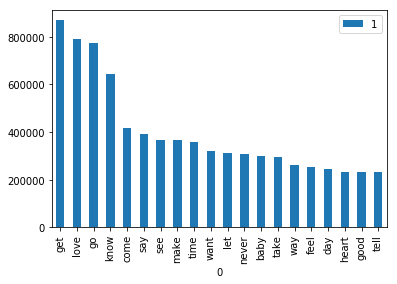

In [9]:
import pandas as pd
%matplotlib inline

df = pd.DataFrame.from_dict(word_freq.most_common(20))
df.plot(x=0, kind ='bar')

### 2. Word representation
#### 1. BOW and Tf-idf

* Using gensim's corpora we create a dictionary. A dictionary is the mapping of each word to an id.
* With this dictionary we create a bag of words **(BOW)** for each document, which is a list of tuples, with information of each token id (from the dictionary) and the number of times it appears in each document.
* Finally with the **BOWs** we create a term frequency - inverse document frequency model **(Tf-Idf)**, this model transforms each word frequency to its importance score in every document. The bigger the number, the more common.

In [10]:
import gensim.corpora as corpora
from gensim.models import TfidfModel

id2word = corpora.Dictionary(lyrics)
id2word.save("../dataset/lemma_lyrics_train_dict")

bow_corpus = list()

for lyric in lyrics:
    bow_corpus.append(id2word.doc2bow(lyric))

tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]
print(bow_corpus[0])
print(tfidf_corpus[0])

[(0, 1), (1, 1), (2, 3), (3, 2), (4, 1), (5, 3), (6, 1), (7, 1), (8, 1), (9, 1), (10, 6), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 5), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 8), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 6), (32, 1), (33, 1), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 2)]
[(0, 0.05050256214874476), (1, 0.025122530928744054), (2, 0.14279105086038593), (3, 0.24129580225127475), (4, 0.07797905183568289), (5, 0.16370106498487164), (6, 0.047403979013047555), (7, 0.12469862755597139), (8, 0.09571123272229458), (9, 0.025206958473365775), (10, 0.25658550775277406), (11, 0.041113128467029914), (12, 0.029516923849726345), (13, 0.07229369295368901), (14, 0.1357658857781773), (15, 0.03307279636442535), (16, 0.0444030583925647), (17, 0.02326400794162864), (18, 0.4256297207931181), (19, 0.1350881521546753), (20, 0.06838955435103246), (21, 0.2467533333977841), (22, 0.07727833379747401), (23, 0.04721633985794173), (24, 0.207

#### 2. Word2Vec
* Word2Vec transforms a collection of documents and produces a vector space of each word.
* These vector are close to the vectors that are common to them.
* Word2Vec is a neural network of two dimmensions
* Here we use the continuos bag of word (CBOW) algorithm, that tries to predict a word based on its context. This is useful since skip-gram instead tries to predict the context, making it slower but more accurate on infrequent words. In our case, musicians have a small vocabulary.

In [11]:
from gensim.models.word2vec import Word2Vec

word2vec = Word2Vec(lyrics, workers=4, iter=3)
word_vectors = word2vec.wv
word2vec.save("../dataset/word2vec")

Now lets see the most similar words

In [12]:
word_vectors.similar_by_word("love")

[('loving', 0.7701539397239685),
 ('baby', 0.7042819857597351),
 ('know', 0.7012172341346741),
 ('darling', 0.682202935218811),
 ('true', 0.6760869026184082),
 ('heart', 0.6710026860237122),
 ('darlin', 0.6579426527023315),
 ('give', 0.6524695158004761),
 ('want', 0.6352090239524841),
 ('babe', 0.6331420540809631)]

In [32]:
word_vectors.similar_by_word("rain")

[('sunshine', 0.633388340473175),
 ('sheepdog_stand', 0.6010996103286743),
 ('raining_rain', 0.5640571713447571),
 ('window_pane', 0.5555225610733032),
 ('storm', 0.5495771169662476),
 ('windowpane', 0.5440040230751038),
 ('raindrop', 0.5405232310295105),
 ('cloud', 0.5361436605453491),
 ('pain', 0.5341677069664001),
 ('pour', 0.5333867073059082)]

In [14]:
word_vectors.similar_by_word("god")

[('lord', 0.651718020439148),
 ('almighty', 0.6372431516647339),
 ('bless', 0.6261026859283447),
 ('blessed', 0.6015845537185669),
 ('father', 0.5930107235908508),
 ('pray', 0.5761238932609558),
 ('satan', 0.5749498605728149),
 ('holy', 0.574797511100769),
 ('righteous', 0.5715709924697876),
 ('savior', 0.5677430629730225)]

In [31]:
word_vectors.similar_by_word("bitch")

[('hoe', 0.8093695640563965),
 ('nigga', 0.7972370982170105),
 ('fuck', 0.7798311710357666),
 ('shit', 0.7647175788879395),
 ('niggas', 0.7626884579658508),
 ('motherfucker', 0.7600331902503967),
 ('fuckin', 0.7324705719947815),
 ('pussy', 0.723581075668335),
 ('dick', 0.7203412055969238),
 ('ass', 0.7102826833724976)]

### 7. Doc2Vec
* This model adds an extra description to the Word2Vec model, this model also adds a representation related to the document, not only the words.

In [16]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_lyrics = [TaggedDocument(lyric, [i]) for i, lyric in enumerate(lyrics)]

doc2vec = Doc2Vec(tagged_lyrics, workers=4, epochs=3)
doc_vectors = doc2vec.docvecs

doc2vec.save("../dataset/doc2vec")

Lets see the most similar documents to the given document

In [34]:
new_vector = doc2vec.infer_vector(['loving', 'baby', 'darling', 'love', 'heart', 'give', 'heart'])
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1], sim[0])

['yonder_whether', 'false', 'true', 'remain', 'wander', 'growing_fonder', 'even', 'friend', 'forsake', 'even', 'succeed', 'glad', 'take', 'give', 'break', 'need', 'know', 'know', 'girl', 'heart', 'love', 'lately', 'find', 'mind', 'know', 'right', 'wrong', 'girl', 'heart', 'string', 'need', 'much', 'ever', 'know', 'ever', 'know', 'love', 'way', 'nothing', 'love', 'may', 'give', 'baby', 'live', 'cry', 'cry', 'get', 'tired', 'say', 'good', 'bye', 'show', 'ever', 'know'] 0.7993189096450806 154130
['go', 'undecided', 'go', 'sit', 'fence', 'make', 'much', 'sense', 'because', 'keep', 'suspense', 'know', 'promise', 'return', 'really', 'burn', 'well', 'guess', 'never', 'learn', 'show', 'get', 'heart', 'kind', 'keep', 'apart', 'make', 'mind', 'undecided', 'go', 'first', 'say', 'say', 'undecided', 'go', 'want', 'play', 'say', 'stay'] 0.7964844703674316 9693
['get', 'outta', 'head', 'head', 'outta', 'head', 'get', 'outta', 'head', 'get', 'heart', 'get', 'outta', 'head', 'head', 'outta', 'get', 'ou

In [35]:
new_vector = doc2vec.infer_vector("rain sunshine storm raindrop".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['know', 'love', 'til', 'learn', 'meaning', 'blue', 'love', 'love', 'lose', 'know', 'love', 'know', 'lip', 'hurt', 'kiss', 'pay', 'cost', 'flip', 'heart', 'lose', 'know', 'love', 'know', 'lose', 'heart', 'fear', 'think', 'reminisce', 'lip', 'taste', 'tear', 'lose', 'taste', 'kissing', 'know', 'heart', 'burn', 'love', 'live', 'yet', 'never', 'die', 'face', 'dawn', 'sleepless', 'eye', 'know', 'love'] 0.7828497886657715
['look', 'heart', 'grew_tipsy', 'alone', 'bring', 'gypsy', 'naughty', 'baby', 'come', 'papa', 'come', 'papa', 'sweet_embraceable', 'love', 'many', 'charm', 'want', 'arm', 'embrace', 'sweet_embraceable', 'embrace', 'irreplaceable'] 0.7769672870635986
['hear', 'music', 'look', 'beautiful', 'theme', 'dream', 'ever', 'know', 'deep', 'heart', 'hear', 'play', 'feel', 'start', 'melt', 'beautiful_rhapsody', 'love', 'youth', 'spring', 'music', 'sweet', 'word', 'true', 'song', 'hear', 'music', 'touch', 'hand', 'beautiful', 'melody', 'enchanted', 'land', 'deep', 'heart', 'hear', 'say

In [19]:
new_vector = doc2vec.infer_vector("god".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['never', 'know', 'much', 'miss', 'never', 'know', 'much', 'care', 'try', 'still', 'hide', 'love', 'ought', 'know', 'tell', 'time', 'go', 'away', 'heart', 'go', 'speak', 'name', 'prayer', 'way', 'prove', 'love', 'way', 'prove', 'love', 'swear', 'know', 'never', 'know', 'know', 'never', 'know', 'know', 'swear', 'know', 'never', 'know', 'know', 'go', 'away', 'heart', 'go', 'speak', 'name', 'prayer'] 0.8575865626335144
['night', 'star', 'shine', 'bright', 'myst_ry', 'fading', 'light', 'shin', 'caravan', 'sleep', 'shoulder', 'creep', 'sand', 'may', 'keep', 'mem_ry', 'caravan', 'excite', 'inviting_resting', 'arm', 'thrill', 'magic', 'charm', 'blue', 'dream', 'love', 'come', 'true', 'desert_caravan'] 0.849493145942688
['bury', 'fuck', 'dead'] 0.848635196685791
['dear', 'love', 'stay', 'together', 'go', 'long', 'long', 'way', 'time', 'rockies_may', 'crumble_gibraltar', 'may', 'tumble', 'make', 'clay', 'love', 'stay', 'time', 'rockies_may', 'crumble_gibraltar', 'may', 'tumble', 'make', 'clay',

In [20]:
new_vector = doc2vec.infer_vector("dog".split())
sims = doc_vectors.most_similar([new_vector], topn=5)
for sim in sims:
    print(lyrics[sim[0]], sim[1])

['dear', 'love', 'stay', 'together', 'go', 'long', 'long', 'way', 'time', 'rockies_may', 'crumble_gibraltar', 'may', 'tumble', 'make', 'clay', 'love', 'stay', 'clear', 'love', 'stay', 'year', 'ever', 'day', 'radio', 'telephone', 'movie', 'know', 'may', 'passing_fancie', 'time', 'may', 'go', 'time', 'rockies_may', 'crumble_gibraltar', 'may', 'tumble', 'make', 'clay', 'love', 'stay'] 0.830255925655365
['say', 'old', 'say', 'love', 'blind', 'still', 'often', 'tell', 'seek', 'ye', 'shall', 'find', 'go', 'seek_certain', 'lad', 'mind', 'look', 'everywhere', 'find', 'yet_hes', 'big', 'affair', 'can', 'not', 'forget', 'man', 'ever', 'think', 'regret', 'add', 'initial', 'monogram', 'tell', 'shepherd', 'lose', 'lamb', 'somebody', 'longing', 'see', 'hope', 'turn', 'someone', 'watch', 'little', 'lamb', 'lose', 'wood', 'know', 'could', 'always', 'good', 'someone', 'watch', 'may', 'man', 'girl', 'think', 'handsome', 'heart', 'carry', 'key', 'tell', 'put', 'speed', 'follow', 'lead', 'need', 'someone'